In [162]:
import pandas as pd
import matplotlib.pyplot as plt

use userbased similarity to predict user rating on an item. data from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce 
1. Compute similarity between users using ratings on items. Users who rated the same item similarly have higher similarity. Usual formula used is the pearson correlation coefficient. This will be the user similarity matrix.
2. To predict an item rating for a user using the similarity matrix
    1. Find users who have rated the item.
    2. Find the top 20 most similar users to the user
    3. Average the ratings of those users for that item.
    4. This average rating is now the predicted rating.
3. To recommend items to a user 
    1. predict the rating for all the items. 
    2. Return the top 20 ratings. (Maybe try things that has not been bought yet)

In [163]:
olist_geolocation_dataset = pd.read_csv('Dataset/olist_geolocation_dataset.csv')
olist_customers_dataset = pd.read_csv('Dataset/olist_customers_dataset.csv')
olist_orders_dataset = pd.read_csv('Dataset/olist_orders_dataset.csv')
olist_order_payments_dataset = pd.read_csv('Dataset/olist_order_payments_dataset.csv')
olist_order_reviews_dataset = pd.read_csv('Dataset/olist_order_reviews_dataset.csv')
olist_order_items_dataset = pd.read_csv('Dataset/olist_order_items_dataset.csv')
olist_products_dataset = pd.read_csv('Dataset/olist_products_dataset.csv')

## EDA
try to wordcloud the reviews

In [164]:
import string

new_df = olist_order_reviews_dataset.copy()
translator = str.maketrans('', '', string.punctuation)
new_df['review_comment_message'] = new_df['review_comment_message'].fillna("").astype('str')
new_df['review_comment_message'] = new_df['review_comment_message'].str.lower()
new_df['review_comment_message'] = new_df['review_comment_message'].str.translate(translator)
new_df['review_comment_message'] = new_df['review_comment_message'].str.split()

word_set = set()
for word_list in new_df['review_comment_message']:
    word_set = word_set.union(set(word_list))

print(word_set)

word_count = dict()
for word in word_set:
    word_count[word] = 0

for word_list in new_df['review_comment_message']:
    for word in list(word_list):
        word_count[word] += 1
    
dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))
# nltk.word_tokenize("""hello, mama""")


{'rapideztop', 'devolva', 'm√™s', 'mostram', 'guia', 'lindopequeno', 'descascou', 'presta√ßao', '2410', 'outron√£o', 'estoquepois', 'arrasa', 'exposta', 'bijuterias', '170418', 'porcentagem', 'verifique', 'receb√≠', '240818', 'frouxo', 'sw', 'satifeito', 'problemapago', 'direitopois', 'lacre', 'resolu√ß√£o', 'starkcomo', 'satisfeitotanto', 'voltagem', 'empoeirada', 'completou', 'satisfeit√≠ssimofelicidades', 'spotify', 'quis', 'discut√≠vel', 'kiwi', 'vieram', 'per√≠cula', 'rel√≥giotem', 'madaram', 'pre√ßa', 'parcialmentedo', '96', 've√™m', 'escapulario', 'feriado', 'berco', 'grudenta', 'comprometeu', 'recebipor', 'coberdron', 'sevolvendo', 'modo', 'terceirizar', 'dizer', 'descrevendo', 'quintal', 'comunica', '1ano', 'acondicionada', 'assinatura', 'acrilico', '2a', 'viagens', 'cortesia', 'novamentw', 't√©rmino', 'cetinho', '10000üëç', 'nenem', 'coberto', 'invicta', '92', 'geladeira', 'numera√ß√£o', 'princesinha', 'rasgar', 'abol√ßa', 'notaaaaaaaaaaaaaaaaa10', 'fun√ß√£o', 'apagado', 'tr

{'o': 18719,
 'produto': 18157,
 'e': 15650,
 'a': 12155,
 'de': 11306,
 'do': 11143,
 'n√£o': 10710,
 'que': 8306,
 'prazo': 8252,
 'muito': 7822,
 'entrega': 6408,
 'antes': 5608,
 'com': 5593,
 'chegou': 5467,
 'recebi': 5235,
 'no': 5042,
 'foi': 4523,
 '√©': 4513,
 'bom': 4512,
 'um': 4338,
 'recomendo': 4165,
 'entregue': 3750,
 'da': 3510,
 'em': 3486,
 'veio': 3244,
 'para': 3159,
 'bem': 3083,
 'na': 3022,
 'mas': 2840,
 'comprei': 2733,
 'qualidade': 2700,
 'uma': 2655,
 'eu': 2386,
 'loja': 2357,
 'ainda': 2304,
 'tudo': 2298,
 'compra': 2163,
 'mais': 2050,
 'meu': 2031,
 'gostei': 1861,
 '√≥timo': 1789,
 'estou': 1782,
 's√≥': 1776,
 'excelente': 1767,
 'como': 1763,
 'at√©': 1745,
 'super': 1670,
 'dentro': 1453,
 'as': 1448,
 'por': 1436,
 'os': 1435,
 'me': 1413,
 'r√°pida': 1386,
 'minha': 1342,
 'nao': 1323,
 'boa': 1299,
 'dia': 1297,
 'pedido': 1290,
 'j√°': 1288,
 'produtos': 1232,
 'se': 1194,
 'site': 1164,
 'sem': 1146,
 'lannister': 1094,
 'pois': 1008,
 'mesmo

The word count may indicate which characteristics people care about like prazo(deadline), entregue (delivery). This confirms that delivery times are correlated with review score.

(-0.5, 5999.5, 1999.5, -0.5)

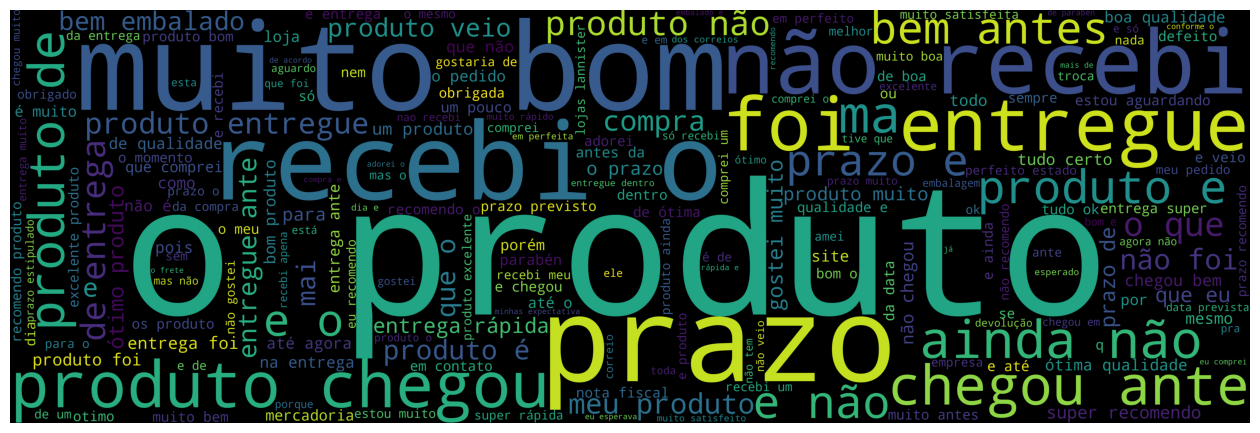

In [165]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

new_df = olist_order_reviews_dataset.copy()
translator = str.maketrans('', '', string.punctuation)
new_df['review_comment_message'] = new_df['review_comment_message'].str.lower()
new_df['review_comment_message'] = new_df['review_comment_message'].fillna("").astype('str')
review_corpus = ' '.join(new_df['review_comment_message'])
review_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=6000,).generate(review_corpus)
plt.figure(figsize=(16,8))
plt.imshow(review_wordcloud)
plt.axis('off')

Use content based filtering to recommend item to a user
1. Compute similarity between users using ratings on items. Users who rated the same item similarly have higher similarity. Usual formula used is the pearson correlation coefficient. This will be the user similarity matrix.

In [166]:
target_cols = ['review_score', 'customer_unique_id', 'product_id']

In [167]:
new_df = (
        olist_order_reviews_dataset
        .set_index('order_id')
        .join(olist_orders_dataset.set_index('order_id'))
        .reset_index()
        .set_index('customer_id')
        .join(olist_customers_dataset.set_index('customer_id'))
        .set_index('order_id')
        .join(olist_order_items_dataset.set_index('order_id'))[target_cols]
        .reset_index()
        .drop('order_id', axis=1)
        )

grouped_df = new_df.groupby(['customer_unique_id', 'product_id'])
result_df = grouped_df.mean().reset_index()
# result_df = result_df.set_index('customer_unique_id')

In [168]:
test_df = result_df.sample(frac=0.02).pivot(index='customer_unique_id', columns='product_id', values='review_score')
test_df.head()

product_id                        000b8f95fcb9e0096488278317764d19  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        008cff0e5792219fae03e570f980b330  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        009af1277432f1a05742df69cdf72d1e  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        009df2b0bc078648fc4f5898de8cabff  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        00c407e056c74eb8040a1233ca6da16f  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        0105b5323d24fc655f73052694dbbb3a  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        01078a94cb29913dfda1a962fd4e3400  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        0116f3b947377cccf0135f8071b54d74  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        01175f0c6182b4410c669417d7e8268f  \
cu

mean center the ratings before computing for pearson correlation

In [169]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_df_scaled = scaler.fit_transform(test_df.T).T
test_df_scaled = pd.DataFrame(test_df_scaled, index=test_df.index, columns=test_df.columns)
test_df_scaled.head()
# user_sim = test_df.corr(method='pearson')

product_id                        000b8f95fcb9e0096488278317764d19  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        008cff0e5792219fae03e570f980b330  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        009af1277432f1a05742df69cdf72d1e  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        009df2b0bc078648fc4f5898de8cabff  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        00c407e056c74eb8040a1233ca6da16f  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        0105b5323d24fc655f73052694dbbb3a  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        01078a94cb29913dfda1a962fd4e3400  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        0116f3b947377cccf0135f8071b54d74  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   

product_id                        01175f0c6182b4410c669417d7e8268f  \
cu

Generate the pearson correlation matrix which will serve as the user-user similarity matrix

In [170]:
corr = test_df_scaled.T.corr(method='pearson')
corr

customer_unique_id                000d460961d6dbfa3ec6c9f5805769e1  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   
...                                                            ...   
ff6447d093bbfa558c51f13162c9a2c7                               NaN   
ff6c80eff6bc50a0c3b10abd65847a2a                               NaN   
ffafb9f09293653c2486abe52e5e05a4                               NaN   
fff2ae16b99c6f3c785f0e052f2a9cfb                               NaN   
fff96bc586f78b1f070da28c4977e810                               NaN   

customer_unique_id                002471155ecd08d208d1376720e2a907  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   
...                                                            ...   
ff6447d093bbfa558c51f13162c9a2c7                               NaN   
ff6c80eff6bc50a0c3b10abd65847a2a                               NaN   
ffafb9f09293653c2486abe52e5e05a4                               NaN   
fff2ae16b99c6f3c785f0e052f2a9cfb                               NaN   
fff96bc586f78b1f070da28c4977e810                               NaN   

customer_unique_id                0027324a96d26a2bc7d69262f83c8403  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   
...                                                            ...   
ff6447d093bbfa558c51f13162c9a2c7                               NaN   
ff6c80eff6bc50a0c3b10abd65847a2a                               NaN   
ffafb9f09293653c2486abe52e5e05a4                               NaN   
fff2ae16b99c6f3c785f0e052f2a9cfb                               NaN   
fff96bc586f78b1f070da28c4977e810                               NaN   

customer_unique_id                0028a7d8db7b0247652509358ad8d755  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7d8db7b0247652509358ad8d755                               NaN   
0048a779a98a7848514096ff04046079                               NaN   
...                                                            ...   
ff6447d093bbfa558c51f13162c9a2c7                               NaN   
ff6c80eff6bc50a0c3b10abd65847a2a                               NaN   
ffafb9f09293653c2486abe52e5e05a4                               NaN   
fff2ae16b99c6f3c785f0e052f2a9cfb                               NaN   
fff96bc586f78b1f070da28c4977e810                               NaN   

customer_unique_id                0048a779a98a7848514096ff04046079  \
customer_unique_id                                                   
000d460961d6dbfa3ec6c9f5805769e1                               NaN   
002471155ecd08d208d1376720e2a907                               NaN   
0027324a96d26a2bc7d69262f83c8403                               NaN   
0028a7

In [175]:
item = test_df.columns[0]
user = test_df.index[100]

def predict_review_score(user: str, item: str) -> float:
    # select users that rated the item
    users = pd.DataFrame(test_df.loc[:, item][test_df.loc[:, item].notnull()])

    # select the similarity score of the users from the similarity matrix
    user_neighborhood = users.join(corr).drop(item, axis=1)

    # get top 20 similar users
    top_users_neighborhood = pd.DataFrame(user_neighborhood.loc[:, user]).sort_values(by=user, ascending=False)[:20]

    # return the mean item review score of the top 20 most similar users 
    return top_users_neighborhood.join(test_df).loc[:, item].mean()

predict_review_score(user, item)

5.0

recommend top predicted reviews

In [ ]:
# Using apply to get row index and column names
def col_predicted_review(row):
    return [predict_review_score(row.name, col) for col in row.index]

user = test_df.index[400]
top_products = pd.DataFrame(test_df.T[user]).apply(col_predicted_review).sort_values(by=user, ascending=False)[:20]
top_products.join(olist_products_dataset.set_index('product_id')).rename(columns={user: 'predicted_review'})[['predicted_review', 'product_category_name']]

In [182]:
user = test_df.index[20]
top_products = pd.DataFrame(test_df.T[user]).apply(col_predicted_review).sort_values(by=user, ascending=False)[:20]
top_products.join(olist_products_dataset.set_index('product_id')).rename(columns={user: 'predicted_review'})[['predicted_review', 'product_category_name']]

predicted_review   product_category_name
product_id                                                                
000b8f95fcb9e0096488278317764d19               5.0   utilidades_domesticas
9539cddd99ab3f8ca77b6cad0a0899ea               5.0           esporte_lazer
94dfe961f86c1f33e5387b6c59201fc7               5.0      ferramentas_jardim
94dc79036088835c91a1608825b3207d               5.0   utilidades_domesticas
94938d42be4ea1064db3325c385ee6d6               5.0           esporte_lazer
93c480c7d11c68ba0a71e850da61b674               5.0  informatica_acessorios
93a12c289ca2b78e7069e469f5053ef2               5.0  informatica_acessorios
9394a725ee7e3f1da0d6b22b046cc8d4               5.0              brinquedos
926a505f318353d8634f3c5102756352               5.0         cama_mesa_banho
9256d5ffeddcdb1ee516de53414ff1a2               5.0               telefonia
9254168b843ffb0932fe40f2687e205a               5.0              brinquedos
918f54d64e36db4f2560c49199e64e12               5.0  informatica_acessorios
914c9e9af640dd56f48764a225b00f89               5.0       moveis_escritorio
913803e9e4b81c3fed4841cbbfdc59fd               5.0           esporte_lazer
9116a056deb0f453c4f5611141deedc5               5.0            beleza_saude
90ebb732ad20456afe8516eb5fbf75f6               5.0        moveis_decoracao
90e5ed878b30ab97ae49a5709c1dbd5d               5.0               papelaria
94e25ee525bdcdce608d423d902a0372               5.0       alimentos_bebidas
9592cd0b739cc57871c3aecffe15436a               5.0              cool_stuff
90b86c830114ddc888f6380a223ee285               5.0         cama_mesa_banho

The issue arises from the sparsity of the similarity matrix, which allows a few users to dominate the predicted review scores for items. In cases where only one user has reviewed a product, the predicted rating for that product will be solely based on this single review for all other users. To improve this, we could generate predicted reviews only for items that have been reviewed by a substantial number of users. 